<a href="https://colab.research.google.com/github/lgvaz/solar-panel/blob/master/notebooks/fastai_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Jul  2 21:43:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# previous fastai version had a bug on RandomResizedCropGPU for TensorMask
# !pip install fastai --upgrade
# !pip install timm

In [3]:
# !pip install wandb

In [4]:
from fastai.vision.all import *
import wandb

## Data setup

In [5]:
run = wandb.init(project="solar-panel", job_type="scratch")

wandb: Currently logged in as: lgvaz. Use `wandb login --relogin` to force relogin


In [6]:
def data_from_wandb(artifact_name: str, run=None, save_dir=None):
    import wandb

    run = run or wandb.init(project="solar-panel", job_type="dataset-download")
    artifact = run.use_artifact(artifact_name, type="dataset")

    save_dir = Path(save_dir) if save_dir is not None else Path.home() / "data"
    save_dir = save_dir / run.project_name() / artifact.name.split(":")[0]
    save_dir.mkdir(exist_ok=True, parents=True)

    return Path(artifact.download(root=save_dir))

In [7]:
data_dir = data_from_wandb('solar-panel:latest', run=run)

wandb: Downloading large artifact solar-panel:latest, 2512.12MB. 2014 files... Done. 0:0:0.2


In [8]:
def mask_file_from_image_file(image_file):
    data_dir = image_file.parent.parent
    mask_name = image_file.with_suffix('.png').name
    return data_dir / 'masks' / mask_name

In [9]:
image_files = get_image_files(data_dir/'images')
mask_files = get_image_files(data_dir/'masks')

In [10]:
splits = RandomSplitter(seed=42)(image_files)

In [11]:
# get a sample dataset for quicker iteration
splits = (splits[0][:200], splits[1][:100])

In [12]:
image_pipeline = [PILImage.create]
mask_pipeline = [mask_file_from_image_file, PILMask.create]

ds = Datasets(image_files, [image_pipeline, mask_pipeline], splits=splits)

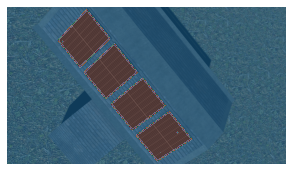

In [13]:
ds.show(ds[29])

## Transforms setup

In [14]:
# after_item = [ToTensor(), Resize(512, 512)]
# after_batch = [IntToFloatTensor(), *aug_transforms(size=(360, 360), min_scale=0.75, flip_vert=True, max_rotate=180)]

# after_item = [ToTensor(), Resize(640, 640)] # 97, 74, 82
# after_batch = [IntToFloatTensor(), *aug_transforms(size=(480, 480), min_scale=0.75, flip_vert=True, max_rotate=180)]

after_item = [ToTensor(), Resize(908, 908)] # 98, 80, 83
after_batch = [IntToFloatTensor(), *aug_transforms(size=(640, 640), min_scale=0.75, flip_vert=True, max_rotate=180)]

dls = ds.dataloaders(bs=4, after_item=after_item, after_batch=after_batch)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


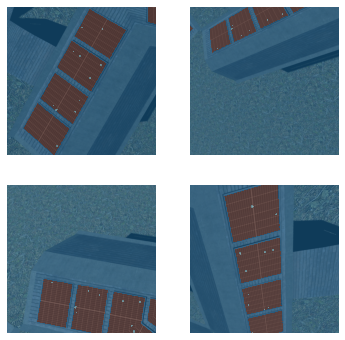

In [15]:
dls.show_batch(unique=True)

In [16]:
def single_class_acc(inp, targ, class_i, axis=1):
    targ = cast(targ.squeeze(1), TensorBase)
    mask = targ == class_i
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()

def panel_acc(inp, targ, axis=1):
    return single_class_acc(inp, targ, 1, axis=axis)

def fault_acc(inp, targ, axis=1):
    return single_class_acc(inp, targ, 2, axis=axis)

## Model setup

In [17]:
metrics = [foreground_acc, panel_acc, fault_acc, DiceMulti]

In [18]:
loss_func = CrossEntropyLossFlat(axis=1, weight=tensor([1.0, 1.0, 10.0]).cuda())

- [ ] try out min_scale = 0.75 combined with size
- [ ] try an ever lower image resolution 224 and see if works

In [19]:
learn = unet_learner(dls, resnet34, n_out=3, metrics=metrics, loss_func=loss_func)
learn.fine_tune(10, 1e-3)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


TypeError: ignored

In [19]:
learn = unet_learner(dls, resnet34, n_out=3, metrics=metrics, loss_func=loss_func)
learn.fine_tune(10, 1e-3)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,foreground_acc,panel_acc,fault_acc,dice_multi,time
0,0.265861,0.062725,0.970569,0.973144,0.000000,0.656536,01:17


epoch,train_loss,valid_loss,foreground_acc,panel_acc,fault_acc,dice_multi,time
0,0.074549,0.055486,0.979971,0.982527,0.016967,0.669324,01:24
1,0.074841,0.064003,0.943428,0.944768,0.425853,0.826687,01:23
2,0.073568,0.053402,0.981830,0.983541,0.327786,0.813589,01:23
3,0.072255,0.041282,0.975816,0.976563,0.682688,0.825944,01:23
4,0.060410,0.037868,0.984087,0.984795,0.706866,0.843687,01:23
5,0.055045,0.035400,0.980508,0.981136,0.734376,0.849559,01:23
6,0.054591,0.038320,0.978400,0.978934,0.768219,0.835533,01:23
7,0.048819,0.035652,0.976408,0.976694,0.863971,0.793690,01:23
8,0.047962,0.035132,0.978908,0.979357,0.803562,0.837124,01:23
9,0.046119,0.034167,0.980722,0.981160,0.809360,0.832326,01:23


In [19]:
# 480
learn = unet_learner(dls, resnet34, n_out=3, metrics=metrics, loss_func=loss_func)
learn.fine_tune(10, 1e-3)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


epoch,train_loss,valid_loss,foreground_acc,panel_acc,fault_acc,dice_multi,time
0,0.293057,0.086782,0.988302,0.990931,0.000070,0.647629,00:44


epoch,train_loss,valid_loss,foreground_acc,panel_acc,fault_acc,dice_multi,time
0,0.085006,0.059484,0.973689,0.976279,0.000302,0.656989,00:46
1,0.076778,0.051226,0.976052,0.977837,0.300110,0.799370,00:48
2,0.070590,0.046629,0.970781,0.972066,0.479392,0.831988,00:48
3,0.066868,0.042436,0.977202,0.978127,0.620216,0.838823,00:48
4,0.060853,0.038659,0.982530,0.983360,0.662224,0.839236,00:48
5,0.058696,0.042647,0.971121,0.971538,0.810241,0.771489,00:48
6,0.060657,0.040147,0.980206,0.980621,0.819845,0.779278,00:48
7,0.058864,0.043517,0.978614,0.978922,0.859433,0.751091,00:48
8,0.054862,0.036705,0.977134,0.977763,0.733079,0.829601,00:48
9,0.052599,0.036810,0.977654,0.978258,0.743828,0.827019,00:48


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


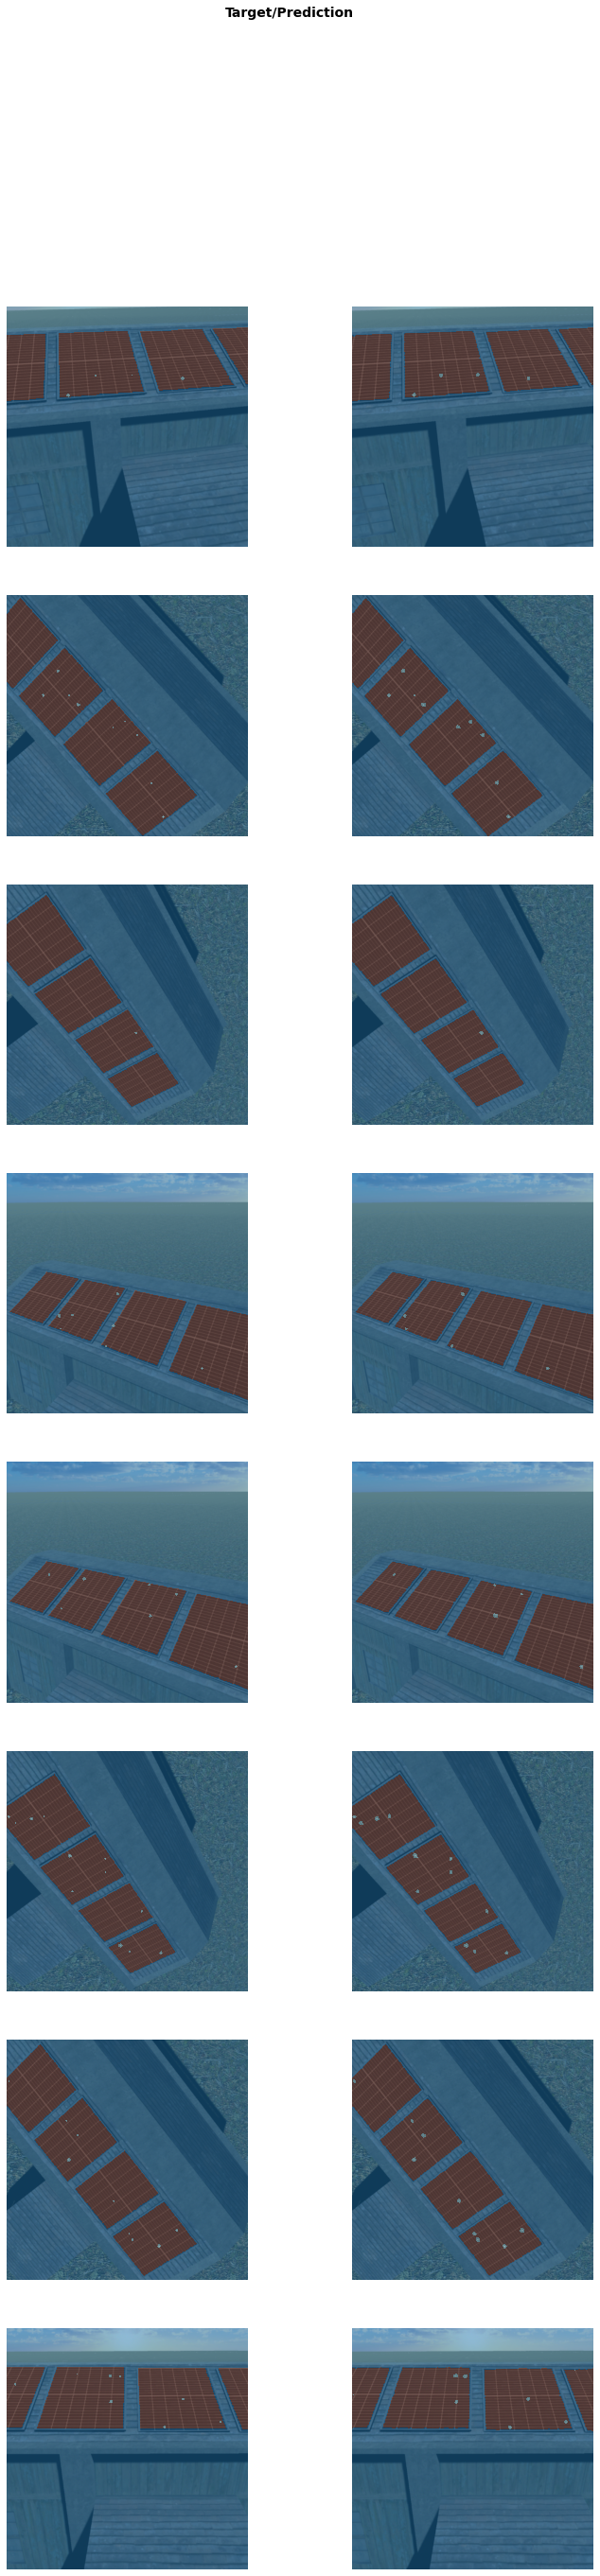

In [20]:
learn.show_results(figsize=(12, 44))

In [26]:
preds, targs = learn.get_preds()

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)
